# Test 6 properties:

* compare eigenvalue decomposition of P and singular value decomposition of $\tilde{P}$

1. convergence of the DM embedding

2. DM embeddings are not addictive in general (i.e., embedding of a data set is not a linear combination of embeddings of its subsets)

3. DM embeddings of data sets under different scalings (e.g. data sets sample from each [0,1] and [0,2]) can be viewed the same by DM

4. sigma effect on DM embeddings

* nonuniform density effect on KMeans

## Define functions

### import libraries

In [1]:
%pylab inline

from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds,eigs
from scipy.stats import norm
from math import ceil
from matplotlib.animation import FuncAnimation as ani
from sklearn.cluster import KMeans

set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


### plot and compare results

In [2]:
def plotemb(EMB,lab='n=',title='embedding'):
    cmap = cm.jet
    col  = cmap(linspace(0,1,len(EMB)))
        
    j = 0
    for i in EMB.keys():
        plot(EMB[i][:,1],EMB[i][:,2], color=col[j], label=lab+i)
        j += 1

    plt.gcf().set_size_inches(6,6)
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def ploteig(EIG,lab='n='):
    cmap = cm.jet
    col = cmap(linspace(0,1,len(EIG)))
    
    dim = len(next(iter(EIG.values())))
    
    j = 0
    print('eigenvalue:')
    for i in EIG.keys():
        plot(range(dim), EIG[i], color=col[j], marker='.', markersize=10, label=lab+i)
        print(EIG[i], lab+i)
        j += 1
        
    plt.gcf().set_size_inches(6,6)
    plt.title('eigenvalues')
    plt.legend()
    plt.show()

In [4]:
def compare(EMB,EIG={}):
    
    I = list(EMB.keys())
    k = I[-1]
    
    delv = []
    dele = []

    j = 1
    for i in I[:-1]:
        if len(EIG)>0: dele.extend(abs(EIG[str(k)] - EIG[i]))

        tmp = (EMB[k][::2**(p-j),:]-EMB[i])**2
        tmp = sum(tmp,axis=0)
        delv.append(sum(tmp)/int(i))
        j += 1

    delv = array(delv).reshape(1,len(I)-1)
    
    if len(EIG)>0: 
        dim  = len(next(iter(EIG.values())))
        dele = array(dele).reshape(len(I)-1,dim)

    return delv, dele

In [5]:
def plotdelta(delta,lab=''):
    p,q = delta.shape
        
    cmap = cm.hsv
    col = cmap(linspace(0,0.65,p))
    
    print(lab+'difference:')
    for i in range(p):
        plot(range(1,q+1),delta[i,:],color=col[i],marker='.',markersize=10,label=lab+str(i))
        print(delta[i,:])

    plt.gcf().set_size_inches(6,6)
    plt.title(lab+'difference')
    if p>1: plt.legend()
    plt.show()

### generate data

In [6]:
def distribution(n,q):
    
    if q==0:
        Q = arange(n)/n
    else:        
        Q = []
        m = int(ceil(n/q))
        scale = 0.02
        tmp = linspace(scale,1-scale,m)
        tmp = norm.ppf(tmp)
        tmp = (tmp-min(tmp))/(max(tmp)-min(tmp))
        
        for j in range(q):            
            Q.extend(tmp+0.9*j)
            
        Q = (sort(array(Q))-min(Q))/(max(Q)-min(Q))
        Q = Q[:n]
        
    return Q.reshape(n,1)

In [7]:
def circle(n,q):
    Q = distribution(n,q)
    Q *= 2*pi
    
    return hstack((cos(Q),sin(Q)))

In [8]:
def line(n,q,flag=1):
    
    Q = distribution(n,q)
    
    if flag: Q /= max(Q)
        
    return hstack((Q, zeros((len(Q),1)) ))

### diffusion maps

In [9]:
def MK(X,Y,sigma):
        
    dist = cdist(X,Y)

    return exp(-dist**2/sigma)

In [10]:
def DM(X,sigma,dim=6):
    
    n = X.shape[0]
    
    K = MK(X,X,sigma)   
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = D.dot(U[:,::-1])
    U /= U[0,0]
            
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = U.dot(diag(S))

    return emb, S, U

In [11]:
def DM2(X,sigma,dim=6):
    
    n = X.shape[0]
    
    K = MK(X,X,sigma)    
    D = diag(1/sum(K,axis=1))
    P = D.dot(K)
    
    S,U = eigs(P,dim)
    
    S = S.real
    U = (U.real)*sqrt(n)
    #U /= U[0,0]
            
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
            
    emb = U.dot(diag(S))
    emb = emb#*sqrt(n)
    
    return emb, S, U

## * compare eigenvalue decomposition of P and singular value decomposition of $\tilde{P}$

In [12]:
def testy(n,sigma):
    EMB = {}
    EIG = {}
    VEC = {}
    
    X = line(n,0)
    
    EMB['eigs'], EIG['eigs'], VEC['eigs'] = DM2(X,sigma)
    EMB['svds'], EIG['svds'], VEC['svds'] = DM(X,sigma)

    return EMB, EIG, VEC

In [13]:
n = 200
sigma = 1

EMBy, EIGy, VECy = testy(n,sigma)

eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] eigs
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] svds


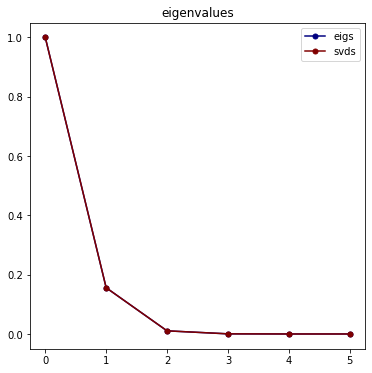

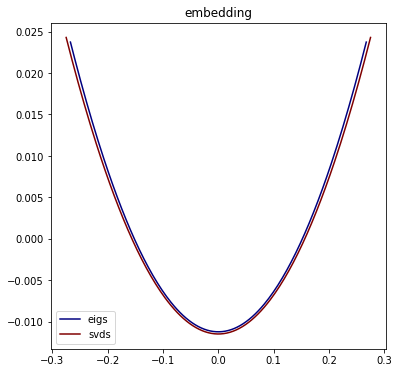

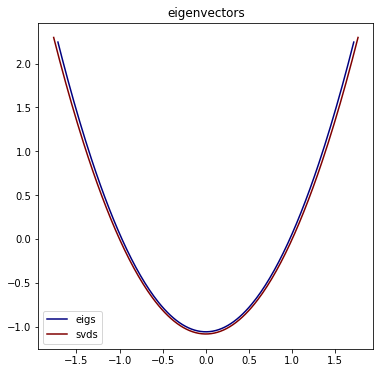

In [14]:
ploteig(EIGy,lab='')
plotemb(EMBy,lab='')
plotemb(VECy,lab='',title='eigenvectors')

## 1. convergence of the DM embedding

See whether the spectrum of diffusion matrix converges to the spectrum of the diffusion operator.

### function: test1(n,p,q,sigma):

input

    n: initial size 
    p: number of time we double the size
    q: distribution parameter (q=0: uniform distribution / q>0: distribution with q peak(s))
    sigma: scaling parameter
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [15]:
def test1(n,p,q,sigma):
    EMB = {}
    EIG = {}
    VEC = {}
    
    for i in range(p):
        
        m = (n-1)*(2**i)+1
        X = line(m,q)
                
        t = time.time()
                                
        EMB[str(m)], EIG[str(m)], VEC[str(m)] = DM(X,sigma)
        
        print('n = ',m, '    duration... ', '%.4f'%(time.time()-t),'s')

    return EMB, EIG, VEC

In [16]:
n = 10+1
p = 8
q = 0    # uniform distribution
sigma = 1

EMB1, EIG1, VEC1 = test1(n,p,q,sigma)

n =  11     duration...  0.0042 s
n =  21     duration...  0.0051 s
n =  41     duration...  0.0044 s
n =  81     duration...  0.0041 s
n =  161     duration...  0.0062 s
n =  321     duration...  0.0147 s
n =  641     duration...  0.0467 s
n =  1281     duration...  0.1798 s


eigenvalue:
[1.00000 0.18262 0.01440 0.00070 0.00002 0.00000] n=11
[1.00000 0.16862 0.01237 0.00058 0.00002 0.00000] n=21
[1.00000 0.16158 0.01137 0.00051 0.00002 0.00000] n=41
[1.00000 0.15805 0.01087 0.00048 0.00002 0.00000] n=81
[1.00000 0.15628 0.01062 0.00046 0.00000 0.00000] n=161
[1.00000 0.15540 0.01050 0.00045 0.00000 0.00000] n=321
[1.00000 0.15495 0.01043 0.00045 0.00000 0.00000] n=641
[1.00000 0.15473 0.01040 0.00045 0.00000 0.00000] n=1281


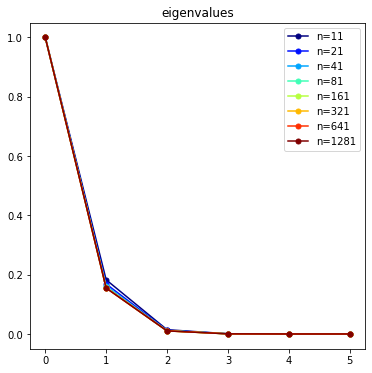

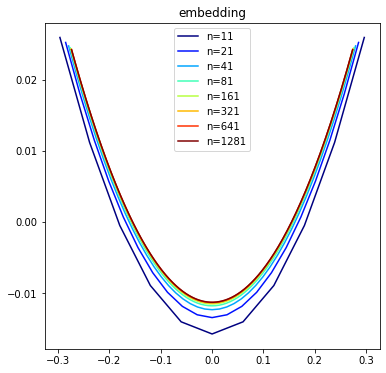

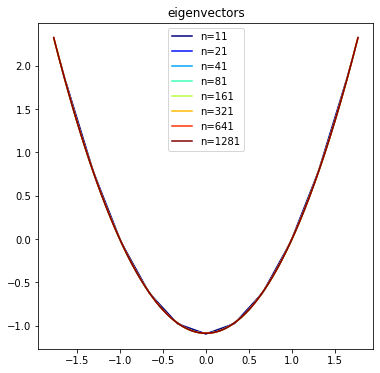

In [17]:
ploteig(EIG1)
plotemb(EMB1)
plotemb(VEC1,title='eigenvectors')

lambda difference:
[0.00000 0.02789 0.00400 0.00025 0.00002 0.00000]
[0.00000 0.01388 0.00197 0.00013 0.00002 0.00000]
[0.00000 0.00685 0.00097 0.00006 0.00002 0.00000]
[0.00000 0.00332 0.00047 0.00003 0.00002 0.00000]
[0.00000 0.00155 0.00022 0.00001 0.00000 0.00000]
[0.00000 0.00066 0.00009 0.00001 0.00000 0.00000]
[0.00000 0.00022 0.00003 0.00000 0.00000 0.00000]


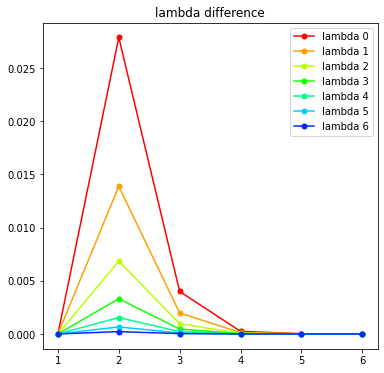

embedding difference:
[0.00022 0.00005 0.00001 0.00000 0.00000 0.00000 0.00000]


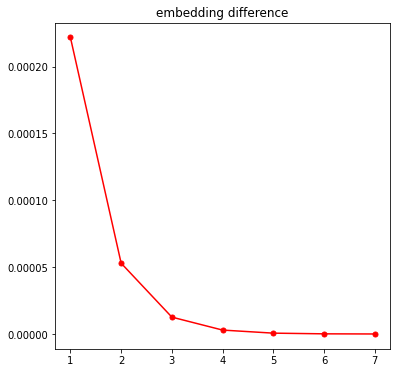

In [18]:
delv1, dele1 = compare(EMB1,EIG1)
plotdelta(dele1,lab='lambda ')
plotdelta(delv1,lab='embedding ')

In [19]:
n = 10+1
p = 8
q = 1    # nonuniform distribution
sigma = 1

EMB12, EIG12, VEC12 = test1(n,p,q,sigma)

n =  11     duration...  0.0012 s
n =  21     duration...  0.0024 s
n =  41     duration...  0.0017 s
n =  81     duration...  0.0022 s
n =  161     duration...  0.0061 s
n =  321     duration...  0.0104 s
n =  641     duration...  0.0362 s
n =  1281     duration...  0.1577 s


eigenvalue:
[1.00000 0.12699 0.01387 0.00074 0.00002 0.00000] n=11
[1.00000 0.10638 0.00952 0.00055 0.00002 0.00000] n=21
[1.00000 0.09677 0.00743 0.00040 0.00000 0.00000] n=41
[1.00000 0.09224 0.00648 0.00032 0.00000 0.00000] n=81
[1.00000 0.09006 0.00604 0.00028 0.00000 0.00000] n=161
[1.00000 0.08899 0.00582 0.00027 0.00000 0.00000] n=321
[1.00000 0.08846 0.00572 0.00026 0.00000 0.00000] n=641
[1.00000 0.08820 0.00567 0.00025 0.00000 0.00000] n=1281


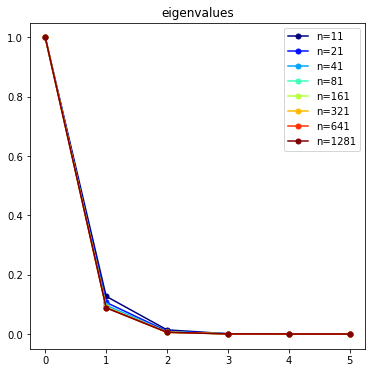

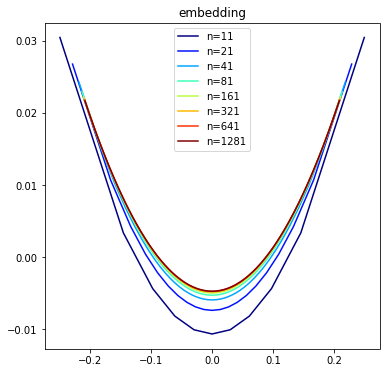

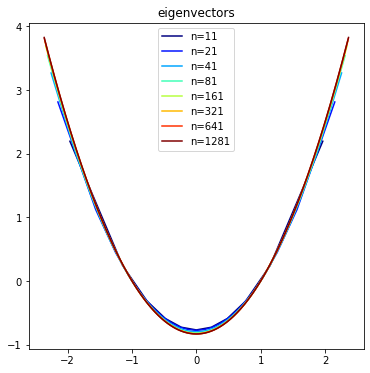

In [20]:
ploteig(EIG12)
plotemb(EMB12)
plotemb(VEC12,title='eigenvectors')

lambda difference:
[0.00000 0.03879 0.00820 0.00048 0.00002 0.00000]
[0.00000 0.01818 0.00385 0.00029 0.00002 0.00000]
[0.00000 0.00858 0.00176 0.00014 0.00000 0.00000]
[0.00000 0.00405 0.00081 0.00007 0.00000 0.00000]
[0.00000 0.00186 0.00036 0.00003 0.00000 0.00000]
[0.00000 0.00079 0.00015 0.00001 0.00000 0.00000]
[0.00000 0.00026 0.00005 0.00000 0.00000 0.00000]


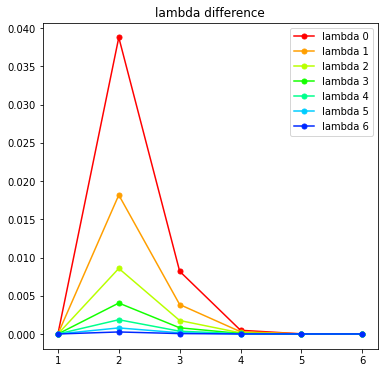

embedding difference:
[0.00051 0.00010 0.00002 0.00000 0.00000 0.00000 0.00000]


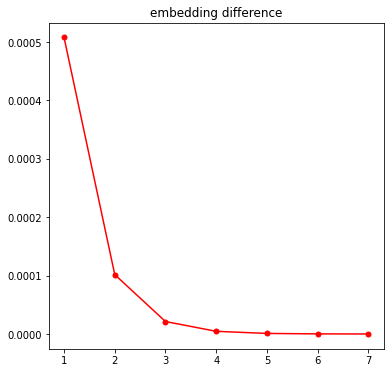

In [21]:
delv12, dele12 = compare(EMB12,EIG12)
plotdelta(dele12,lab='lambda ')
plotdelta(delv12,lab='embedding ')

## 2. partition the data set

Compare the embedding of a data set and the embeddings of its subsets.


### function: test2(n,p,sigma)

input

    n: original data size 
    p: number of partition
    sigma: scaling parameter
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [22]:
def test2(n,p,sigma):
    EMB = {}
    EIG = {}
    VEC = {}
    
    X = line(n,0)        
    m = int(n/p)
    
    EMB['full'], EIG['full'], VEC['full'] = DM(X,sigma)
    
    for i in range(p):
        EMB[str(i)], EIG[str(i)], VEC[str(i)] = DM(X[m*i:m*(i+1)],sigma)
    
    return EMB, EIG, VEC

In [23]:
n = 200
p = 4
sigma = 1

EMB2, EIG2, VEC2 = test2(n,p,sigma)

eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] subset full
[1.00000 0.01047 0.00004 0.00000 0.00000 0.00000] subset 0
[1.00000 0.01047 0.00004 0.00000 0.00000 0.00000] subset 1
[1.00000 0.01047 0.00004 0.00000 0.00000 0.00000] subset 2
[1.00000 0.01047 0.00004 0.00000 0.00000 0.00000] subset 3


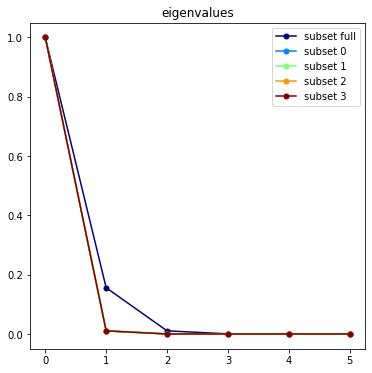

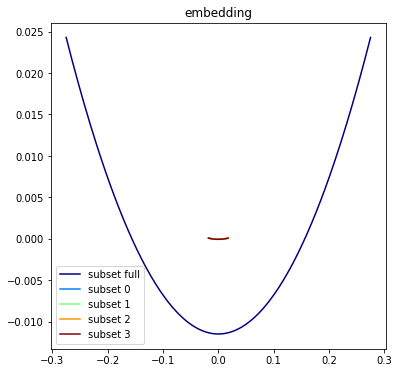

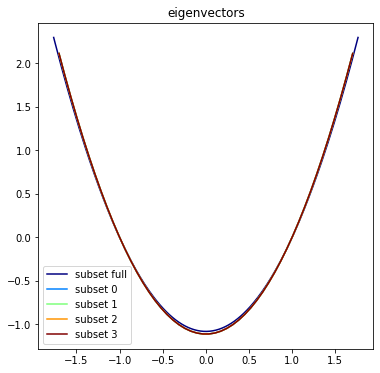

In [24]:
ploteig(EIG2,lab='subset ')
plotemb(EMB2,lab='subset ')
plotemb(VEC2,lab='subset ',title='eigenvectors')

## 3. different intervals

Above testing have dataset being [0,1]. Now we compare the embedding of dataset c*[0,1] with different c's.

### function: test3(n,c,sigma)

input

    n: data size
    c: a sequence of natrual numbers
    sigma: scaling parameter

output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [25]:
def test3(n,c,sigma):
    EMB = {}
    EIG = {}
    VEC = {}
    
    X = line(n,0)
        
    for i in c:
        EMB[str(i)], EIG[str(i)], VEC[str(i)] = DM(X*i,sigma[i-1])
    
    return EMB, EIG, VEC

### sigma is a constant

In [26]:
n = 200
c = arange(1,11)
sigma = [1]*10

EMB3, EIG3, VEC3 = test3(n,c,sigma)

eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=1
[1.00000 0.47278 0.11863 0.02022 0.00258 0.00026] c=2
[1.00000 0.70321 0.31923 0.10923 0.02942 0.00648] c=3
[1.00000 0.82397 0.50419 0.25085 0.10432 0.03691] c=4
[1.00000 0.88687 0.63990 0.39461 0.21269 0.10118] c=5
[1.00000 0.92209 0.73336 0.51645 0.32760 0.18858] c=6
[1.00000 0.94339 0.79741 0.61258 0.43286 0.28316] c=7
[1.00000 0.95712 0.84209 0.68653 0.52283 0.37392] c=8
[1.00000 0.96644 0.87403 0.74318 0.59730 0.45564] c=9
[1.00000 0.97305 0.89747 0.78686 0.65812 0.52674] c=10


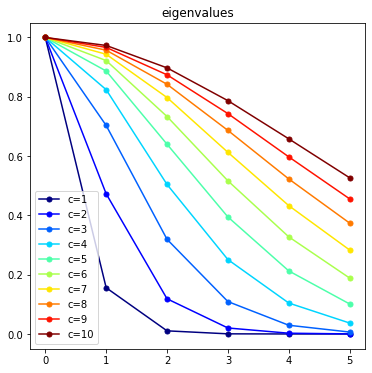

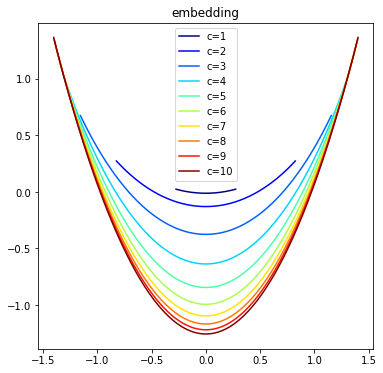

In [27]:
ploteig(EIG3,lab='c=')
plotemb(EMB3,lab='c=')

### sigma scale with c

In [28]:
n = 200
c = arange(1,11)
sigma = c

EMB32, EIG32, VEC32 = test3(n,c,sigma)

eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=1
[1.00000 0.28532 0.03816 0.00331 0.00021 0.00000] c=2
[1.00000 0.38958 0.07603 0.00983 0.00094 0.00007] c=3
[1.00000 0.47278 0.11863 0.02022 0.00258 0.00026] c=4
[1.00000 0.53932 0.16233 0.03402 0.00538 0.00068] c=5
[1.00000 0.59300 0.20502 0.05051 0.00948 0.00143] c=6
[1.00000 0.63680 0.24565 0.06895 0.01491 0.00261] c=7
[1.00000 0.67297 0.28376 0.08870 0.02159 0.00427] c=8
[1.00000 0.70321 0.31923 0.10923 0.02942 0.00648] c=9
[1.00000 0.72876 0.35212 0.13013 0.03824 0.00925] c=10


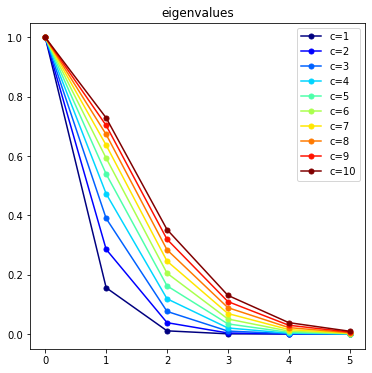

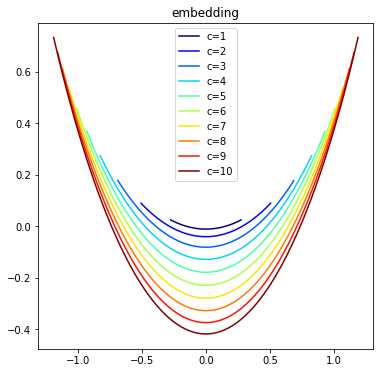

In [29]:
ploteig(EIG32,lab='c=')
plotemb(EMB32,lab='c=')

### sigma scale with c^2

In [30]:
n = 200
c = arange(1,11)
sigma = c**2

EMB33, EIG33, VEC33 = test3(n,c,sigma)

eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=1
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=2
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=3
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=4
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=5
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=6
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=7
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=8
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=9
[1.00000 0.15593 0.01057 0.00046 0.00000 0.00000] c=10


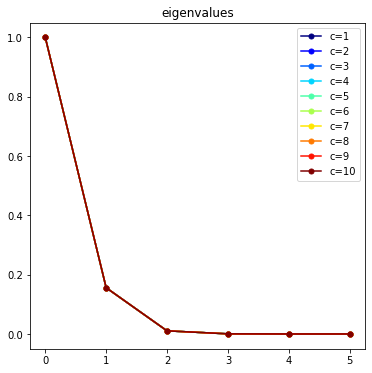

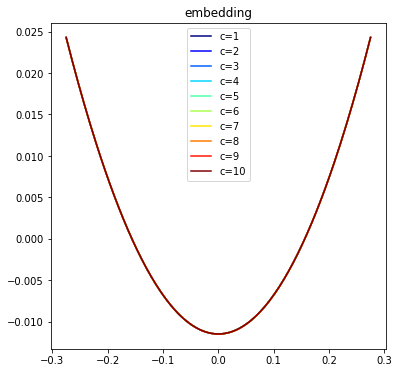

In [31]:
ploteig(EIG33,lab='c=')
plotemb(EMB33,lab='c=')

## 4. sigma effect on DM

For a given dataset, test the effect of setting different sigma's (scaling parameter).

### function:  test4(n,sigma)

input

    n: data size
    sigma: a sequence of scaling parameters; #a values uniformly lie between (0,b]  
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [32]:
def test4(n,sigma):
    EMB = {}
    EIG = {}
    VEC = {}
    
    X = line(n,0)
        
    for i in sigma:
        EMB[str(i)], EIG[str(i)], VEC[str(i)] = DM(X,i)
    
    return EMB, EIG, VEC

In [33]:
n = 200
a = 10
b = .5
sigma = arange(1,a+1)/a*b

EMB4, EIG4, VEC4 = test4(n,sigma)

eigenvalue:
[1.00000 0.85850 0.57433 0.32061 0.15311 0.06336] sigma=0.05
[1.00000 0.72876 0.35212 0.13013 0.03824 0.00925] sigma=0.1
[1.00000 0.62314 0.23237 0.06263 0.01296 0.00216] sigma=0.15
[1.00000 0.53932 0.16233 0.03402 0.00538 0.00068] sigma=0.2
[1.00000 0.47278 0.11863 0.02022 0.00258 0.00026] sigma=0.25
[1.00000 0.41943 0.08992 0.01288 0.00137 0.00012] sigma=0.3
[1.00000 0.37608 0.07022 0.00866 0.00079 0.00006] sigma=0.35
[1.00000 0.34036 0.05620 0.00608 0.00049 0.00003] sigma=0.4
[1.00000 0.31054 0.04591 0.00442 0.00032 0.00002] sigma=0.45
[1.00000 0.28532 0.03816 0.00331 0.00021 0.00000] sigma=0.5


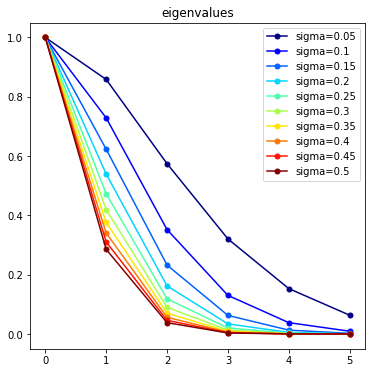

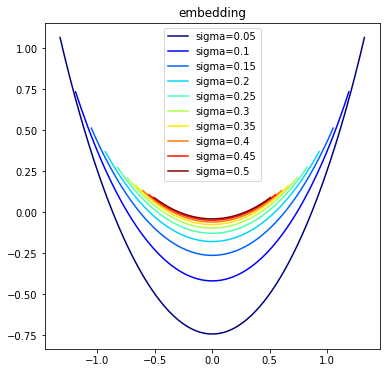

In [34]:
ploteig(EIG4,lab='sigma=')
plotemb(EMB4,lab='sigma=')

In [41]:
n = 200
a = 100
b = .5
sigma = arange(1,a+1)/a*b

EMB42,_,_ = test4(n,sigma)

<IPython.core.display.Javascript object>


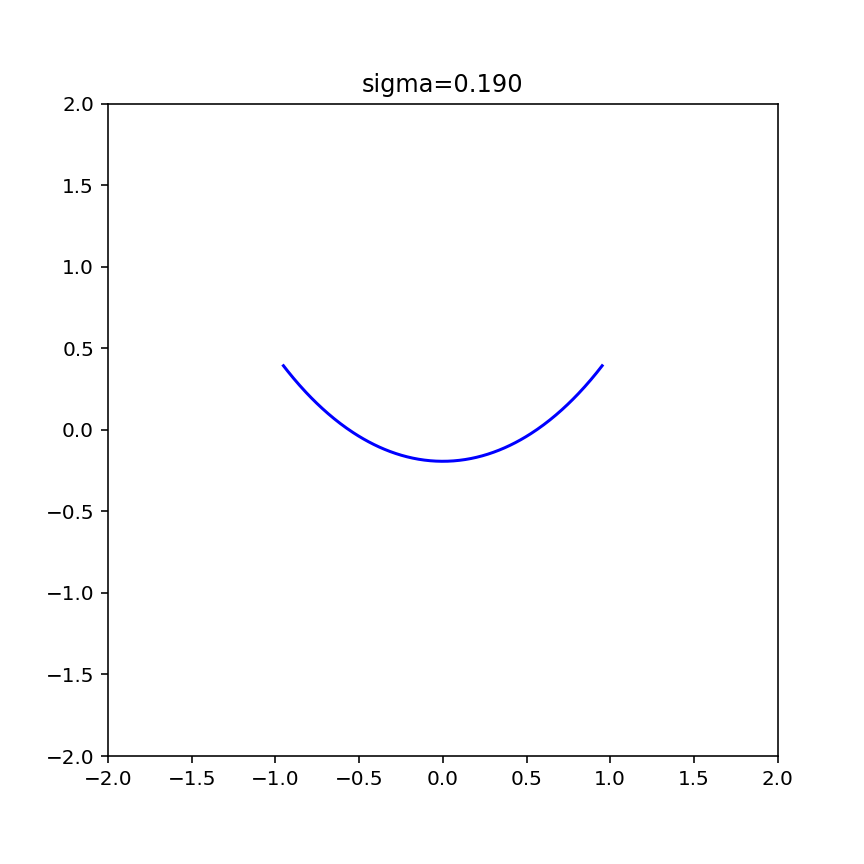

In [42]:
%matplotlib notebook

def animate2(t):
    tmpline.set_data(EMB42[str(t)][:,1],EMB42[str(t)][:,2])
    plt.title('sigma='+str('%.3f'%t))
    return tmpline,

fig = plt.figure(figsize=(6,6))
ax  = plt.axes(xlim =(-2,2), ylim =(-2,2))
tmpline, = ax.plot([],[],color='b')

vid = ani(fig, animate2, frames=sigma, repeat=0, interval=50)

#vid.save('a.gif')
plt.show()

In [43]:
%matplotlib inline

## * nonuniform density effect on KMeans

In [44]:
n = 200
cluster = 10

In [45]:
def testz(X,cluster,size=(6,6)):
    kmeans = KMeans(cluster).fit(X)
    labels = array(kmeans.predict(X))

    cmap = cm.nipy_spectral
    col = cmap(linspace(0,1,cluster))

    for i in range(cluster):
        tmp = argwhere(labels==i)
        scatter(X[tmp,0],X[tmp,1],s=4,color=col[i])

    plt.gcf().set_size_inches(size)
    plt.show()

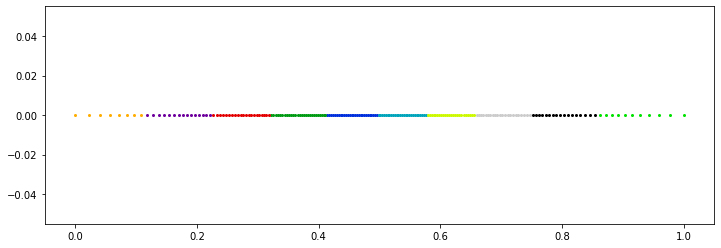

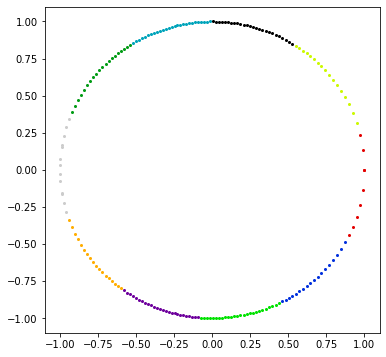

In [46]:
X0 = line(n,1)
testz(X0,cluster,size=(12,4))

X1 = circle(n,2)
testz(X1,cluster)